In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from myDataSet import *
from myNetworks import *
from myUtil import *
from tqdm import tqdm


plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")


In [3]:
# Predefined dictionary to ensure same one-hot encoding for both train and test data.
my_label_map = {}
for i in range(5): my_label_map[str(i)] = i
my_label_map

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [4]:
# Loading all training data
train_data_fname = "trainData.txt"
_ = MyCustomDataset(filename=train_data_fname,
                    skip_rows=0,
                    label_col=0,
                    feature_cols=(1,2),
                    label_map=my_label_map)


# Splitting into training and validation set
validation_fraction = 0.1
my_lengths = (_.__len__()-int(validation_fraction*_.__len__()),  int(validation_fraction*_.__len__()))
training_data, validation_data = torch.utils.data.random_split(dataset=_,
                                                               lengths=my_lengths)
print("## Setting aside:", validation_fraction*100, "% for validation. ##")

# Loading test data
test_data_fname = "testData.txt"
test_data = MyCustomDataset(filename=test_data_fname,
                            skip_rows=0,
                            label_col=0,
                            feature_cols=(1,2),
                            label_map=my_label_map)

# Utilizing torch 'dataloader' framework
my_batch_size = 4
train_dataloader = DataLoader(training_data, batch_size=my_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=my_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=my_batch_size, shuffle=True)
print("  - Using batch size: ", my_batch_size)
print("  - Nr. training batches: ", train_dataloader.__len__())
print("  - Nr. validation batches: ", validation_dataloader.__len__())
print("  - Nr. test batches: ", test_dataloader.__len__())

## Setting aside: 10.0 % for validation. ##
  - Using batch size:  4
  - Nr. training batches:  270
  - Nr. validation batches:  30
  - Nr. test batches:  75


In [5]:
# Creating instance of my neural net
my_number_of_features = 2
my_number_of_classes = 5
my_net = NeuralNet(nr_classes=my_number_of_classes,
                   nr_features=my_number_of_features)

In [6]:
# Training
my_number_of_epochs = 200
my_no_improvement_max = 40
result = my_net.train_network(train_dataloader=train_dataloader,
                              validation_dataloader=validation_dataloader,
                              epochs=my_number_of_epochs,
                              no_improvement_max=my_no_improvement_max,
                              device_name='cpu')

train_accuracies, train_losses, validation_accuracies, validation_losses = result

 49%|████▉     | 98/200 [00:11<00:11,  8.79it/s]

Early stopping due to no validation acc. improvement in:  40 epochs.
Highest validation acc. model saved at epoch:  59 , with validation acc:  99.16666746139526 %


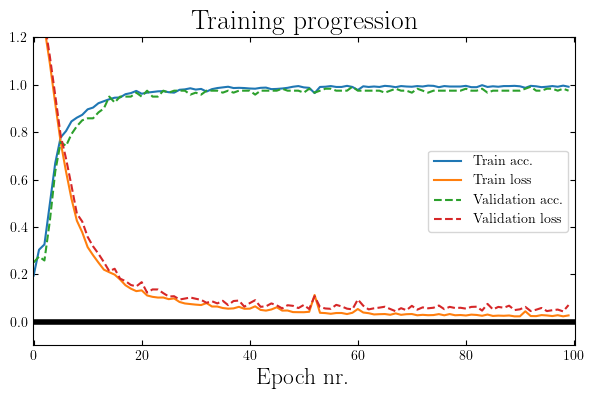

In [7]:
# Plotting
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.set_title("Training progression",size=20)
epochs = [i for i in range(len(train_accuracies))]
ax.plot(epochs,train_accuracies,label="Train acc.")
ax.plot(epochs,train_losses,label="Train loss")
ax.plot(epochs,validation_accuracies,ls='--',label="Validation acc.")
ax.plot(epochs,validation_losses,ls="--",label="Validation loss")
ax.set_ylim(-0.1,1.2)
ax.set_xlim(-0.2,len(train_losses)+.2)
ax.hlines(0,-0.2,len(train_losses)+.2,lw=4,color="k")
ax.set_xlabel("Epoch nr.",size=17)
ax.legend(loc=0)
plt.show()

In [8]:
# Trying model on test data
print("Highest val. acc model:")
my_net.load_state_dict(torch.load("Model/best_val_acc.pt"))
my_net.eval()
test_model(trained_model=my_net,
           data=test_dataloader,
           verbose=False)
print("\n"+80*"-"+"\n")
print("Last epoch model: ")
my_net.load_state_dict(torch.load("Model/final_epoch.pt"))
my_net.eval()
test_model(trained_model=my_net,
           data=test_dataloader,
           verbose=False)

Highest val. acc model:

 #####|  294 / 300  items in  75  test batches predicted correctly ~ acc:  0.98  |#####

--------------------------------------------------------------------------------

Last epoch model: 

 #####|  293 / 300  items in  75  test batches predicted correctly ~ acc:  0.9767  |#####


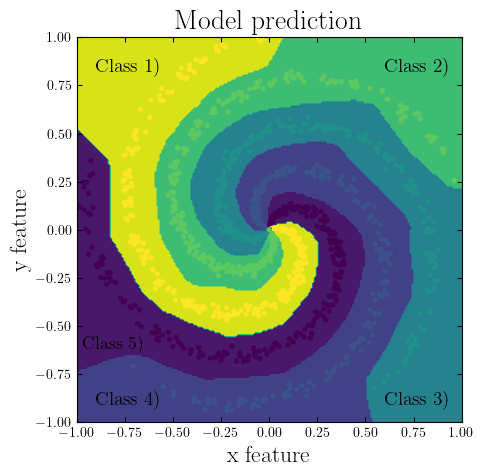

In [41]:
## Plotting model result according to assignment
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_title("Model prediction",size=20)
x,y=np.meshgrid(np.linspace(-1,1,200),np.linspace(-1,1,200))
xy=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
z=my_net(torch.tensor(xy).float()).detach().numpy()
z=np.argmax(z,1).reshape(200,200)
ax.contourf(x,y,z)
ax.set_xlabel("x feature",size=17)
ax.set_ylabel("y feature",size=17)
ax.scatter(training_data.dataset.features[:,0],
            training_data.dataset.features[:,1],
            c=training_data.dataset.labels, ## Colors
            s=8)                           ## Sizes

ax.text(-0.9,0.82,"Class 1)",size=14)
ax.text(0.6,0.82,"Class 2)",size=14)
ax.text(0.6,-0.91,"Class 3)",size=14)
ax.text(-0.9,-0.91,"Class 4)",size=14)
ax.text(-0.97,-0.62,"Class 5)",size=14)
ax.set_aspect("equal")
plt.show()